<center><h2>Python Script that charts bitcoin prices in US dollars</h2></center>

In [2]:
%matplotlib inline

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator, WeekdayLocator, DayLocator, DateFormatter
import dateutil
from matplotlib.ticker import MultipleLocator
from datetime import datetime
from datetime import date

# Data metadata:
# CSV file where first column is string date in dd/mm/YYYY H:M:S format and second column is the bitcoin price in US dollars
# Pandas.read_csv has an awesome converters parameter that allows us to convert or modify a column's data on the fly!
# Therefore, we can read the first column as an actual Python datetime object instead of as a string.
# Because there is time info with the date, it causes the x-axis ticks to not correspond with the data.
# As a workaround, I stripped the time from the date values by invoking datetime.date()
bitcoin_data = pd.read_csv("http://blockchain.info/charts/market-price?showDataPoints=false&timespan=&show_header=true&daysAverageString=1&scale=0&format=csv&address=",
                 index_col=0, names=['price'], converters={0: lambda x: datetime.date(datetime.strptime(x, '%d/%m/%Y %H:%M:%S'))})

#### Let's view just the last 5 rows of the bitcoin data:

In [11]:
bitcoin_data.tail()

,price
2015-02-12,221.83
2015-02-13,239.94
2015-02-14,245.31
2015-02-15,243.99
2015-02-16,231.95


#### Now, let's plot the data.  Top chart will be all data available in monthly x-ticks intervals, bottom chart will be just last 2 calendar months of data, with daily x-ticks intervals.

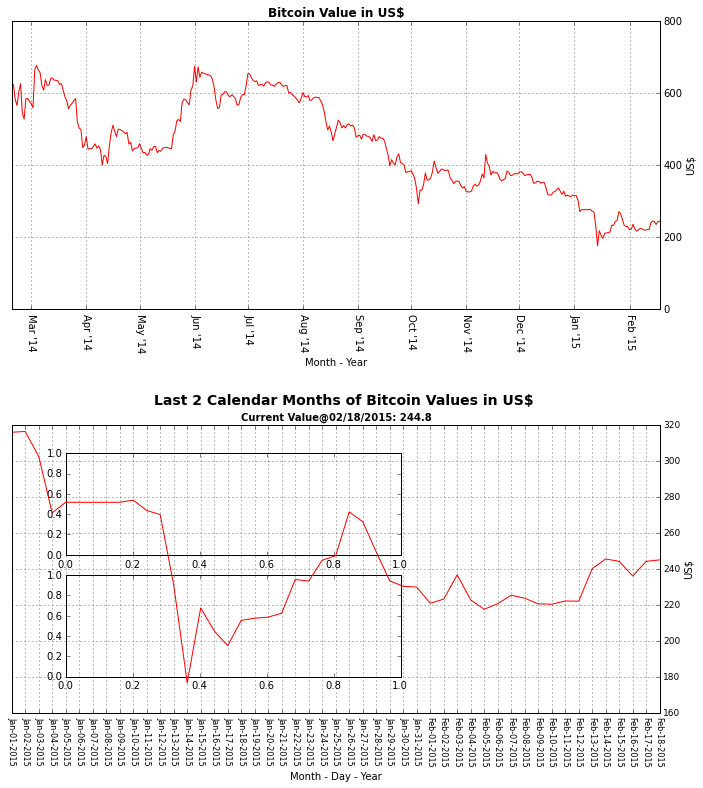

In [3]:
fig, axes = plt.subplots(2, 1)  # Make 2 rows and 1 column of plots (2 plots total)

# These are just time intervals we can use to format our X axis tick intervals
year   = YearLocator()
month  = MonthLocator(bymonth=range(1,13),  bymonthday=1, interval=1)
week   = WeekdayLocator(byweekday=dateutil.rrule.MO)  # Every MOnday or WeekdayLocator(byweekday=0) works too
day    = DayLocator(bymonthday=range(1,32), interval=1)

####################### Let's make the top plot ######################
# Use trial and error to get the size you want
axes[0] = fig.add_axes([0, 1.4, 1.5, 1])  # left, bottom, width, height

# Format the x-axis, set tick labels as Month 'Yr format, turn on grid for major ticks
monthsFmt = DateFormatter("%b '%y")
axes[0].xaxis.set_major_formatter(monthsFmt)
axes[0].xaxis.set_major_locator(month)       # Make the x-axis tick interval to be monthly interval size
axes[0].xaxis.grid(which='major')

# Format the y-axis
y_major_ticks = MultipleLocator(200)
axes[0].yaxis.set_major_locator(y_major_ticks)
axes[0].yaxis.set_ticks_position('right')   # Not sure why 'both' don't work
axes[0].yaxis.set_label_position('right')
axes[0].yaxis.grid(which='major')

# Plot the data...
axes[0].plot_date(bitcoin_data.index, bitcoin_data.values, 'r')
axes[0].set_title("Bitcoin Value in US$", weight="bold")
axes[0].set_xlabel("Month - Year")
axes[0].set_ylabel("US$")
plt.setp(axes[0].get_xticklabels(), rotation=-90)

############# Let's get last 2 calendar months' worth of bitcoin prices ###########
# But first, we must account for situation where current month is January
today = datetime.today()
this_month = today.month
if this_month==1:
    last_year = today.year - 1   # if month is January, then year will be one less than current year
    last_month = 12              # if month is January, then previous month is Dec (12)
else:
    last_year = today.year       # Otherwise, last year is really same as current year and
    last_month = this_month - 1  # last month will equal current month minus 1

this_year = today.year

# Pandas' filtering by date ranges only work if the dates are of type datetime.datetime
# Unfortunately, the data parsed from the CSV file, was parsed as datetime.date
# So we will convert bitcoin_data.index to datetime.datetime:
bitcoin_data.index = pd.to_datetime(bitcoin_data.index)

# Now I will take advantage of Pandas partial string indexing described below to get just 2 months of data:
# http://pandas.pydata.org/pandas-docs/stable/timeseries.html#partial-string-indexing
last2months = bitcoin_data[str(last_month)+'-'+str(last_year):str(this_month)+'-'+str(this_year)]

# Get current price and also the current date, convert it to a datetime.date, then make a string from it in mm/dd/YYYY format
current_price = last2months[-1:].values[0][0]
last_date = last2months[-1:].index
current_date_unformatted = date(last_date.year[0], last_date.month[0], last_date.day[0])
current_date = datetime.strftime(current_date_unformatted, "%m/%d/%Y")

####################### Let's make the bottom plot ######################
axes[1] = fig.add_axes([0, 0, 1.5, 1])   # left, bottom, width, height

# Format the x-axis tick labels as mm/dd/YYYY format, turn on grid for major ticks
dayFmt = DateFormatter("%b-%d-%Y")
axes[1].xaxis.set_major_locator(day)  # Make x-axis tick interval to be daily interval size
axes[1].xaxis.set_major_formatter(dayFmt)
axes[1].xaxis.grid(which='major')

# Format the y-axis
y_major_ticks = MultipleLocator(20)
axes[1].yaxis.set_major_locator(y_major_ticks)
axes[1].yaxis.set_ticks_position('right')  # Not sure why 'both' don't work
axes[1].yaxis.set_label_position('right')
axes[1].yaxis.grid(which='major')

# Plot the data...
axes[1].plot_date(last2months.index, last2months.values, 'r')
axes[1].set_title("Current Value@"+current_date+": "+str(current_price), weight="bold", size=10)
# MATPLOTLIB does not have a good way of creating a title with 2 rows of text with different font sizes
# Below is a workaround(http://matplotlib.org/users/text_intro.html), sort of "hackish" and requires trial and error (x,y)
axes[1].text(.22,1.07, "Last 2 Calendar Months of Bitcoin Values in US$", transform=axes[1].transAxes,
             weight="bold", size=14)
axes[1].set_xlabel("Month - Day - Year")
axes[1].set_ylabel("US$")
plt.setp(axes[1].get_xticklabels(), rotation=-90, size=8)
plt.setp(axes[1].get_yticklabels(), size=9)
plt.show()